In [209]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import gc_colors
import danplotlib as dpl
import re
mpl.rcParams["figure.figsize"] = 18, 10
mpl.rcParams["lines.markeredgewidth"] = 1.0

# Custom function definitions

In [218]:
def get_medians(data, n_parts=4):
    """Helper function for median uniformity."""
    datablocks = np.split(np.asarray(data), n_parts)
    xvalues = np.split(np.asarray(range(len(data))), n_parts)
    medians = []
    for block in datablocks:
        medians.append(np.median(block))
        
    return xvalues, np.asarray(medians)

def get_ledbrightness(filename):
    with open(filename) as f:
        line = f.readline()
        ledbrightness, integrationtime = [ int(s) for s in re.findall(r'\b\d+\b', line) ]
            
    return ledbrightness

# Active area of the photodiodes

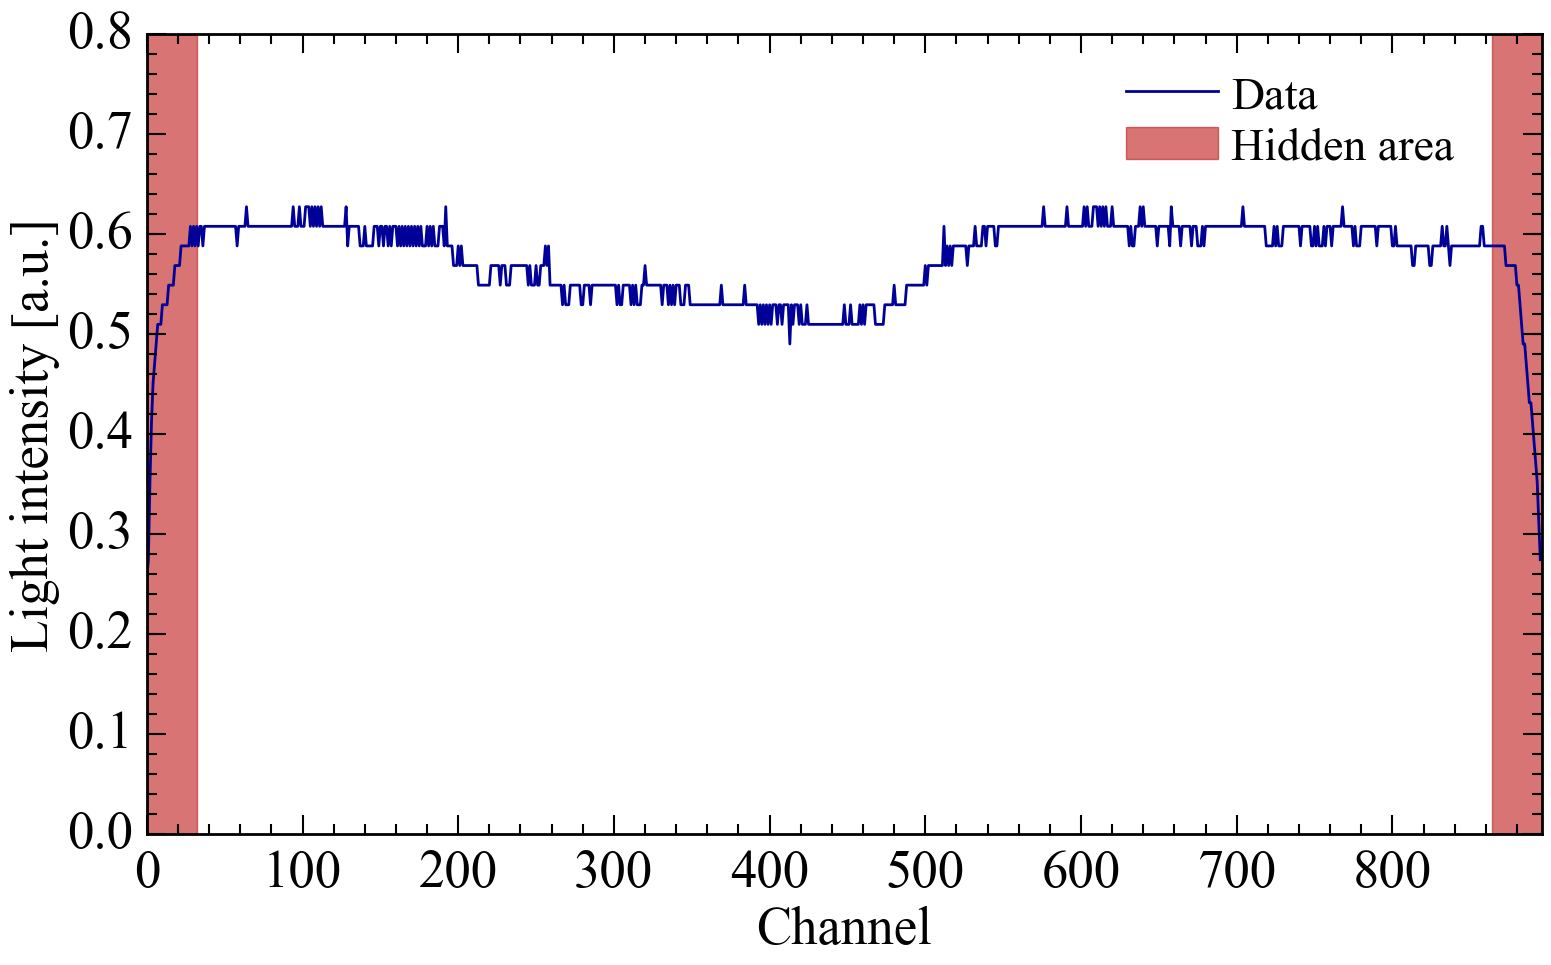

In [97]:
open_data = pd.read_csv("../../Open_Housing.csv", delim_whitespace=True, comment='#', names=["Ch", "Blue", "Red"])
plt.plot(open_data["Blue"], color="gcblue", label="Data")
plt.xlim(0, len(open_data))
plt.ylim(0, 0.8)
plt.xlabel("Channel")
plt.ylabel("Light intensity [a.u.]")
plt.axvspan(0, 32, color="gcred", alpha=0.6, label="Hidden area    ")
plt.axvspan(len(open_data)-32, len(open_data), color="gcred", alpha=0.6)
plt.legend()
plt.minorticks_on()

# Load the data

In [256]:
lightbars = {}
ref_ledbrightness = 25
for lightbar in [107, 111, 122]:
    lightbars[lightbar] = {"Data" : pd.DataFrame()}  #empty dataframe
    #Arduino data
    for transp in ["normal", "distance", "fine", "med", "rough"]:
        filename = "Measurements/HD{0}_{1}.csv".format(lightbar, transp)
        data = pd.read_csv(filename, delim_whitespace=True, comment='#', 
                           names=["Ch", "Blue", "Red"])
        ledbrightness = get_ledbrightness(filename)
        print(filename, "LED brightness: ", ledbrightness)
        lightbars[lightbar]["Data"][transp] = data["Blue"]
        #Scale data according to brightness
        lightbars[lightbar]["Data"][transp]*=ref_ledbrightness/ledbrightness
    
    
    #Mattest data
    mattest_data = pd.read_csv("Measurements/HD{0}_mattest.csv".format(lightbar), sep=";", skiprows=15, 
                               names=["Ch", "Pedestal", "Gain", "Mean_pixels"])
    lightbars[lightbar]["Mattest"] = mattest_data["Mean_pixels"]

Measurements/HD107_normal.csv LED brightness:  10
Measurements/HD107_distance.csv LED brightness:  25
Measurements/HD107_fine.csv LED brightness:  10
Measurements/HD107_med.csv LED brightness:  25
Measurements/HD107_rough.csv LED brightness:  25
Measurements/HD111_normal.csv LED brightness:  10
Measurements/HD111_distance.csv LED brightness:  25
Measurements/HD111_fine.csv LED brightness:  10
Measurements/HD111_med.csv LED brightness:  25
Measurements/HD111_rough.csv LED brightness:  25
Measurements/HD122_normal.csv LED brightness:  8
Measurements/HD122_distance.csv LED brightness:  25
Measurements/HD122_fine.csv LED brightness:  10
Measurements/HD122_med.csv LED brightness:  25
Measurements/HD122_rough.csv LED brightness:  25


# Calculate characteristics

In [222]:
n_channels_cut = 32#Remove the number of channels for the next calculations
n_median_uniformity = 4
for lightbar in lightbars:
    df = lightbars[lightbar]["Data"]
    for column in df.columns:
        data = df[column][n_channels_cut:-n_channels_cut] if n_channels_cut > 0 else df[column]
        mean = np.mean(data)
        std = np.std(data)
        rel_std = std/mean
        
        blocks, medians = get_medians(data, n_median_uniformity)
        uniformity = min(medians)/max(medians)
        
        lightbars[lightbar][column+"_rel_std"] = rel_std
        lightbars[lightbar][column+"_uniformity"] = uniformity


# Plot the data

In [257]:
def plotbars(lightbar_dict, column_list):
    for lightbar in sorted(lightbar_dict):   #sort by number
        Dict = lightbar_dict[lightbar]
        df = Dict["Data"]
        plt.figure()
        for column in column_list:
            dpl.plot(df[column], label="{0}, rel. std = {1:.3f}".format(column, Dict[column+"_rel_std"]))
            plt.xlim(df.index[0], df.index[-1])
        plt.axvspan(0, n_channels_cut, color="gcred", alpha=0.6, label="Hidden area")
        plt.axvspan(len(df[column])-n_channels_cut, len(df[column]), color="gcred", alpha=0.6)
        plt.title("Lightbar HD{}".format(lightbar), fontsize=25)
        plt.legend(bbox_to_anchor = [0.02, 1.01], loc="upper left")
        plt.xlabel("Channel")
        plt.ylabel("Intensity [a.u.]")
        
        
def plotmattest(lightbar_dict):
    for lightbar in sorted(lightbar_dict):
        Dict = lightbar_dict[lightbar]
        df = Dict["Mattest"]
        plt.figure()
        dpl.plot(df)
        plt.xlim(df.index[0], df.index[-1])
        plt.ylim(0, max(df)*1.2)
        plt.title("Lightbar HD{}".format(lightbar), fontsize=25)
        plt.xlabel("Channel")
        plt.ylabel("Intensity [a.u.]")        

## Normal (close distance) vs. larger distance (as large as the plasticbars width) vs. fine plasticbar

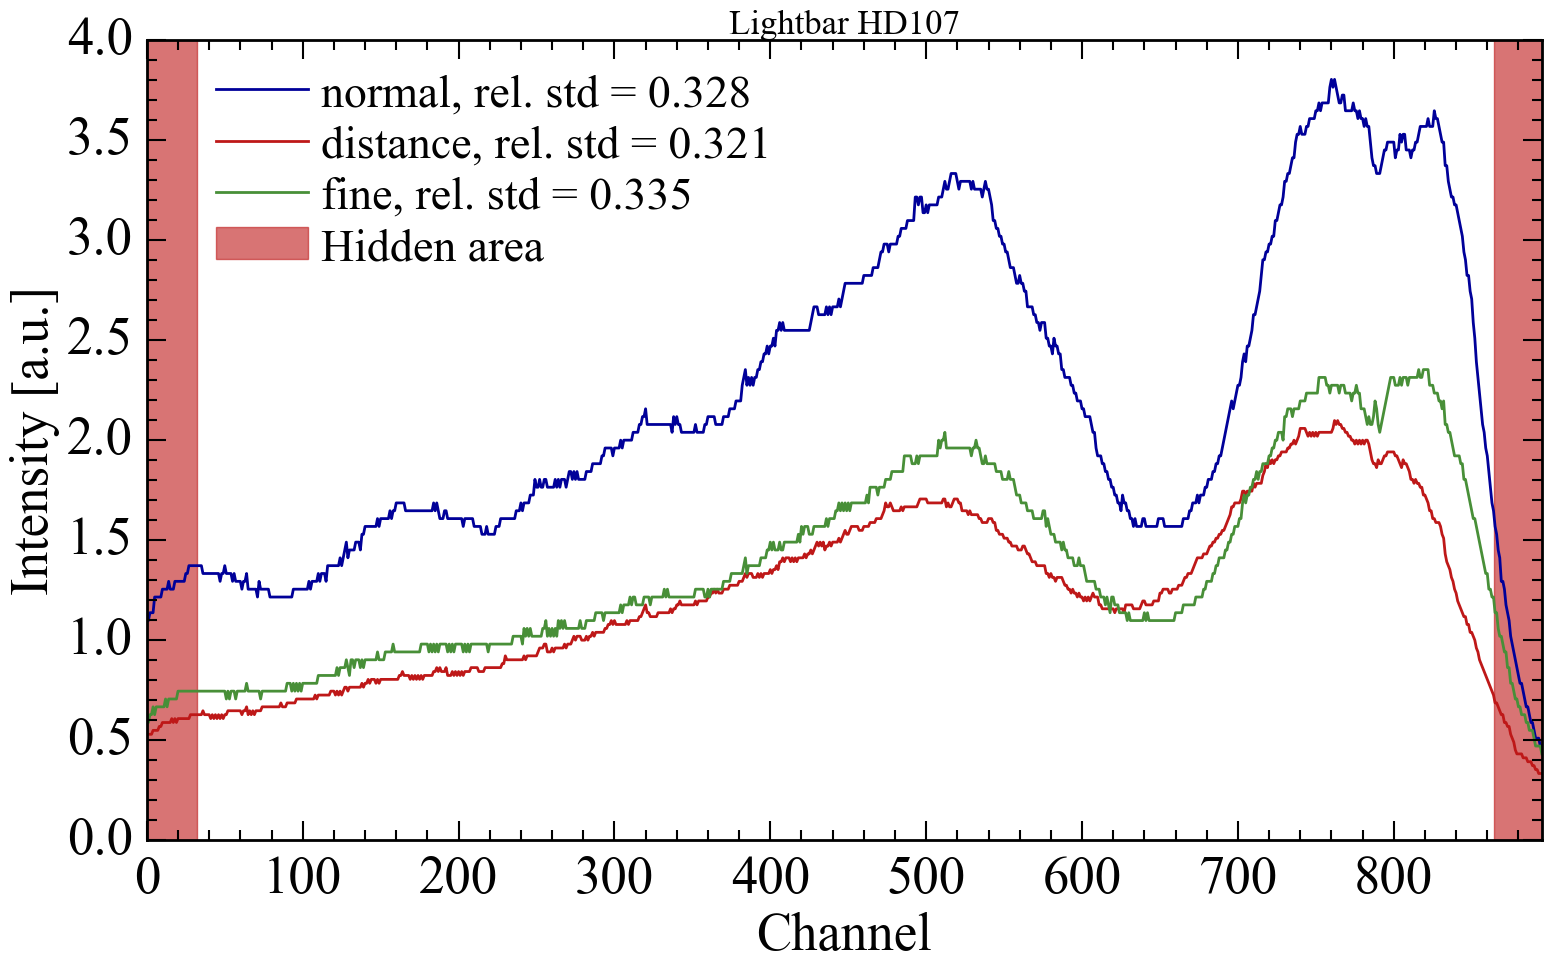

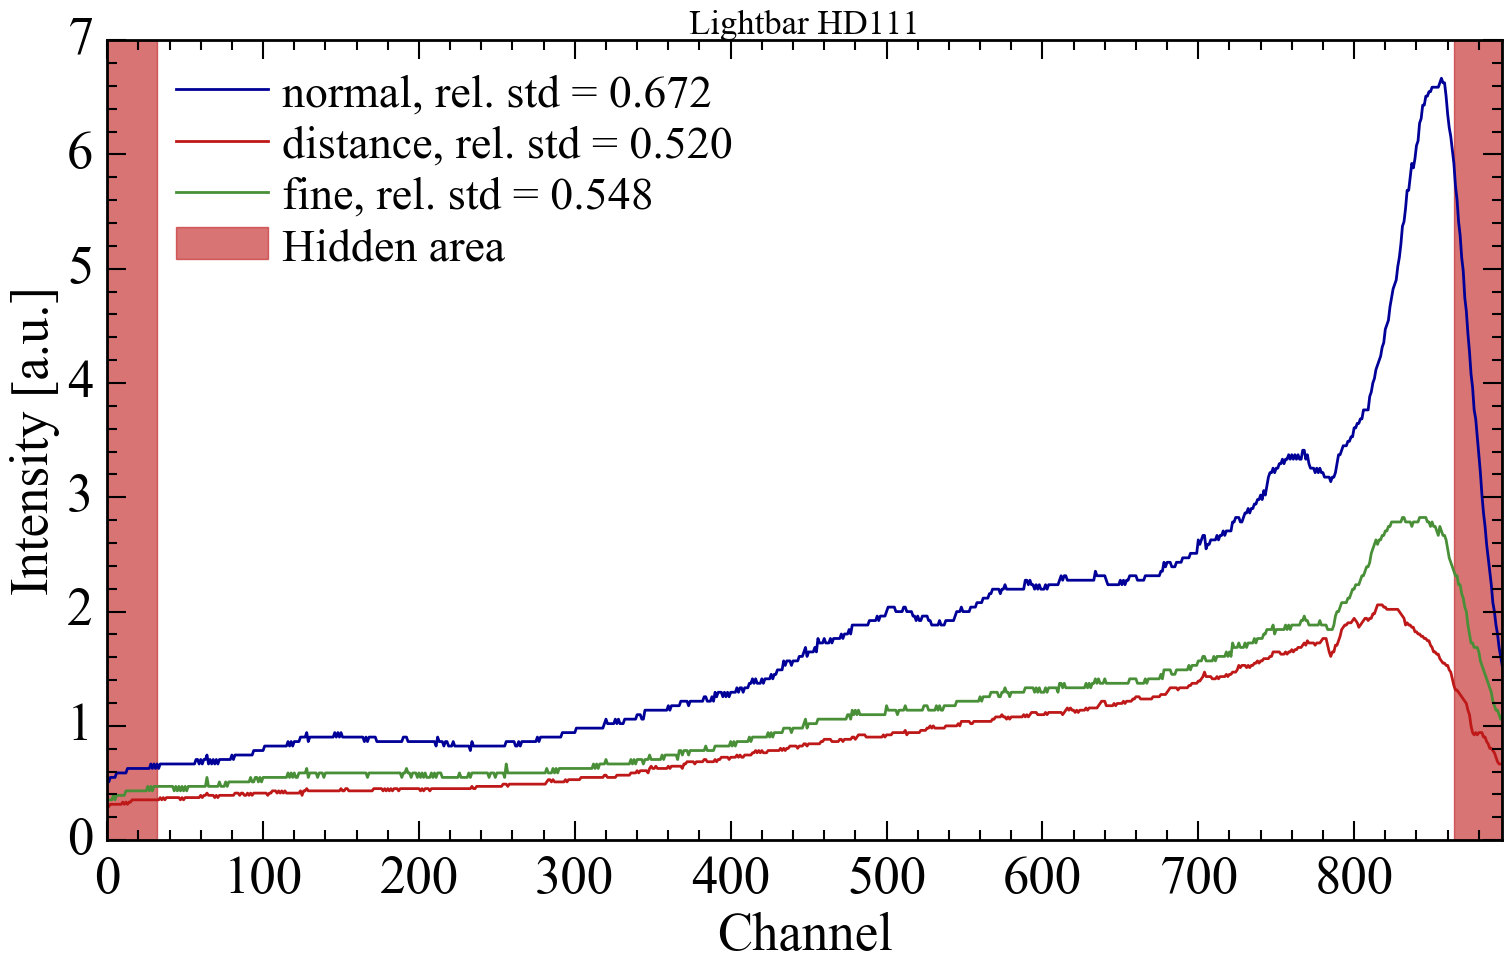

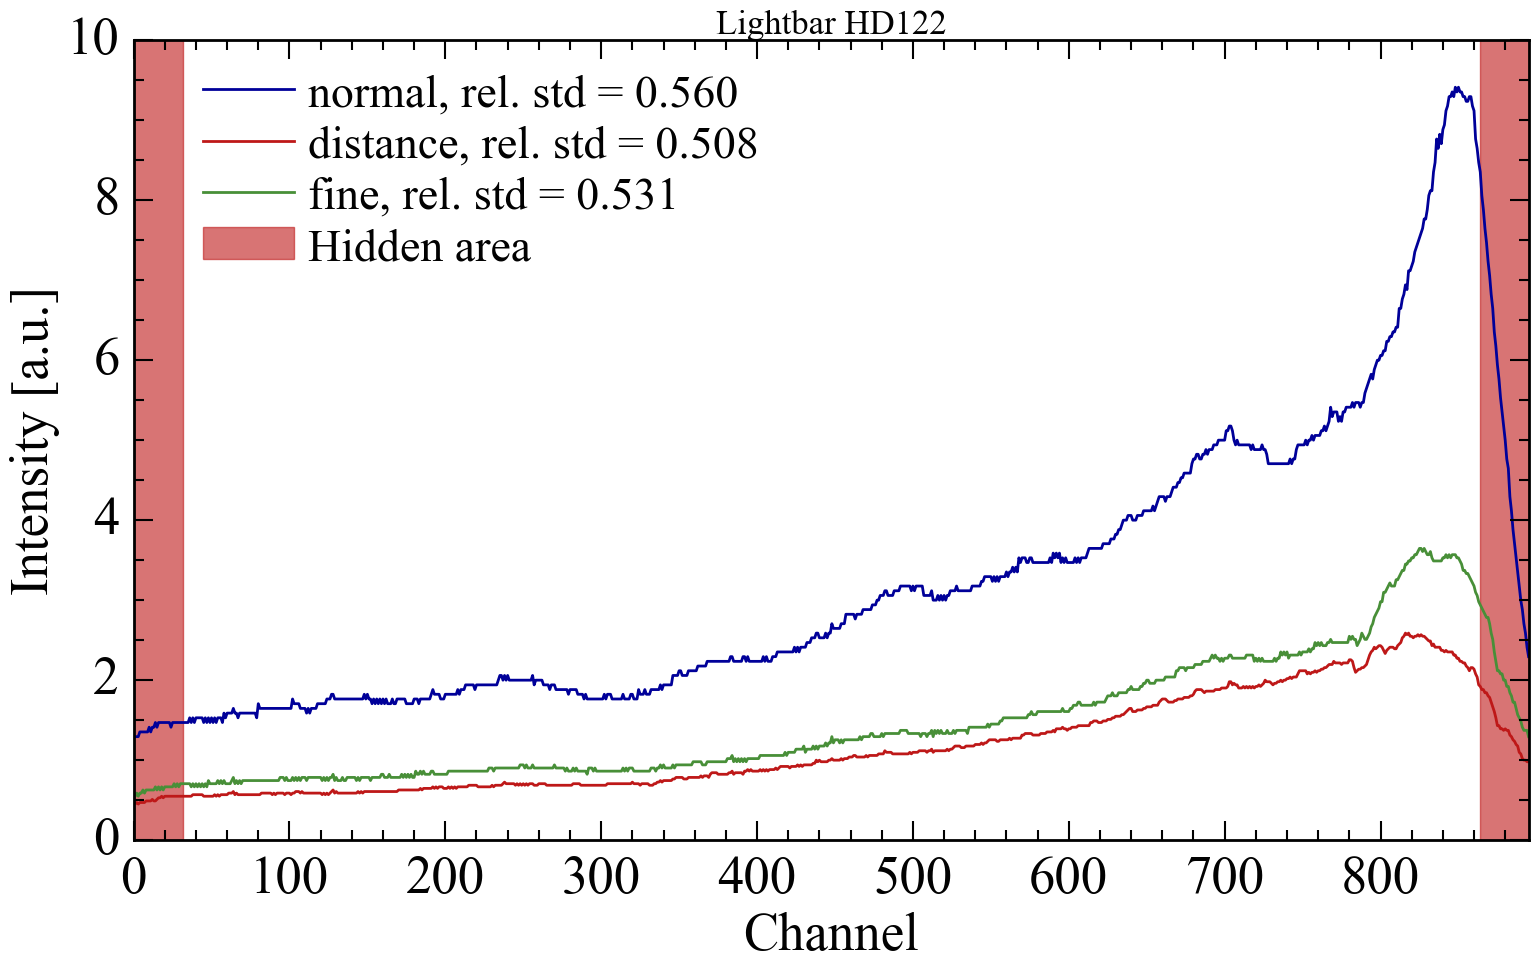

In [248]:
plotbars(lightbars, ["normal", "distance", "fine"])

## Fine vs. med vs. rough

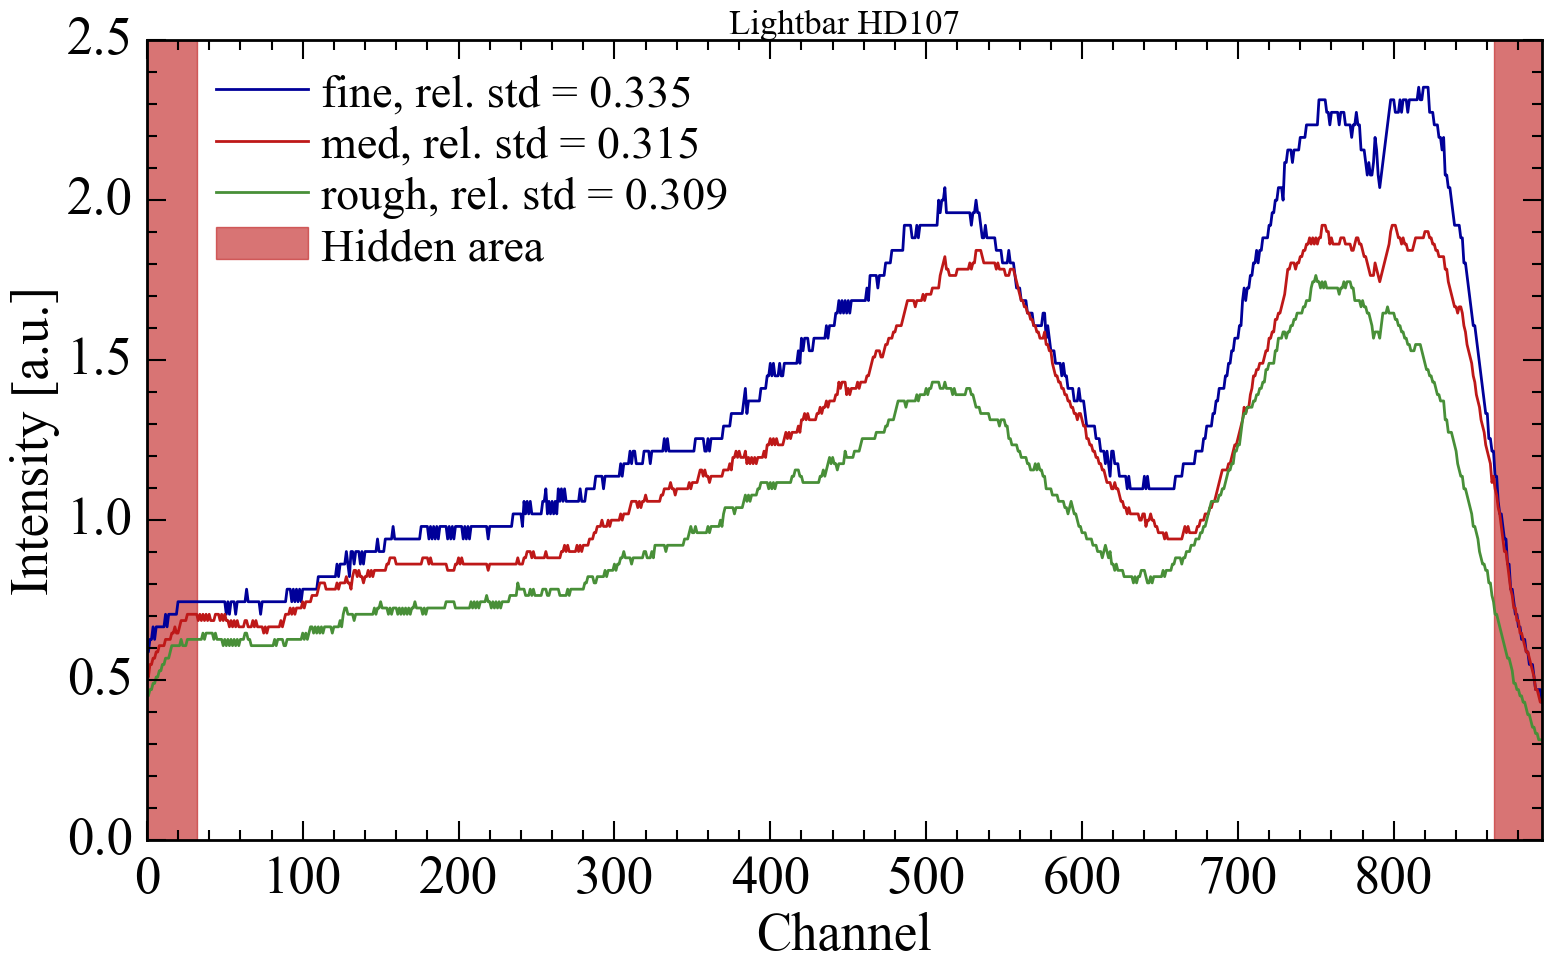

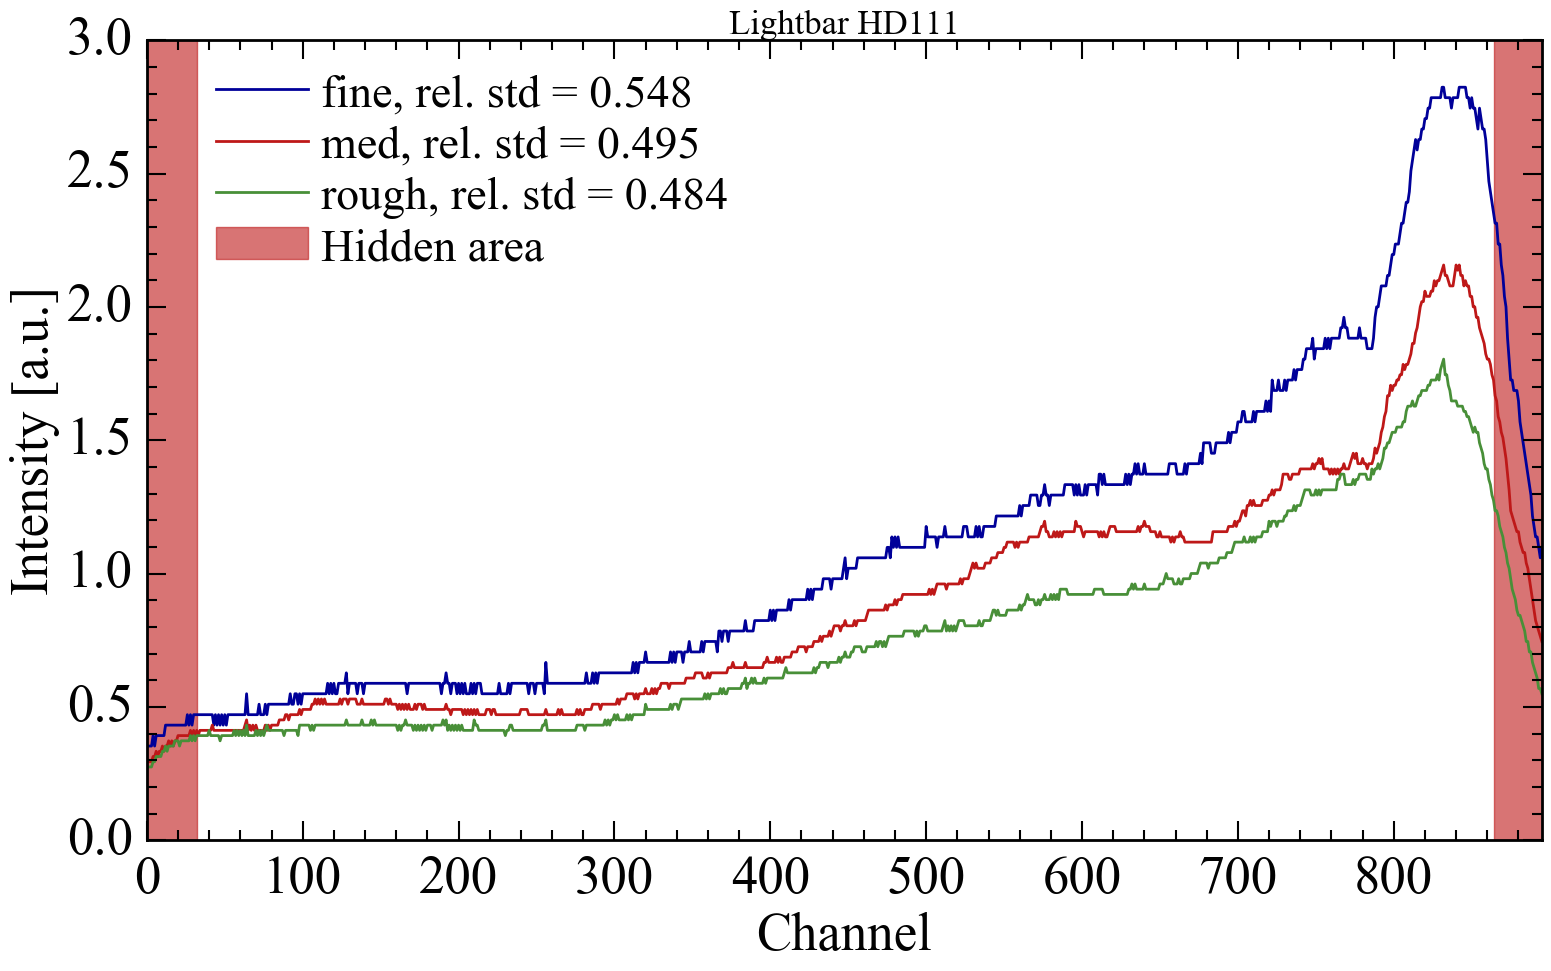

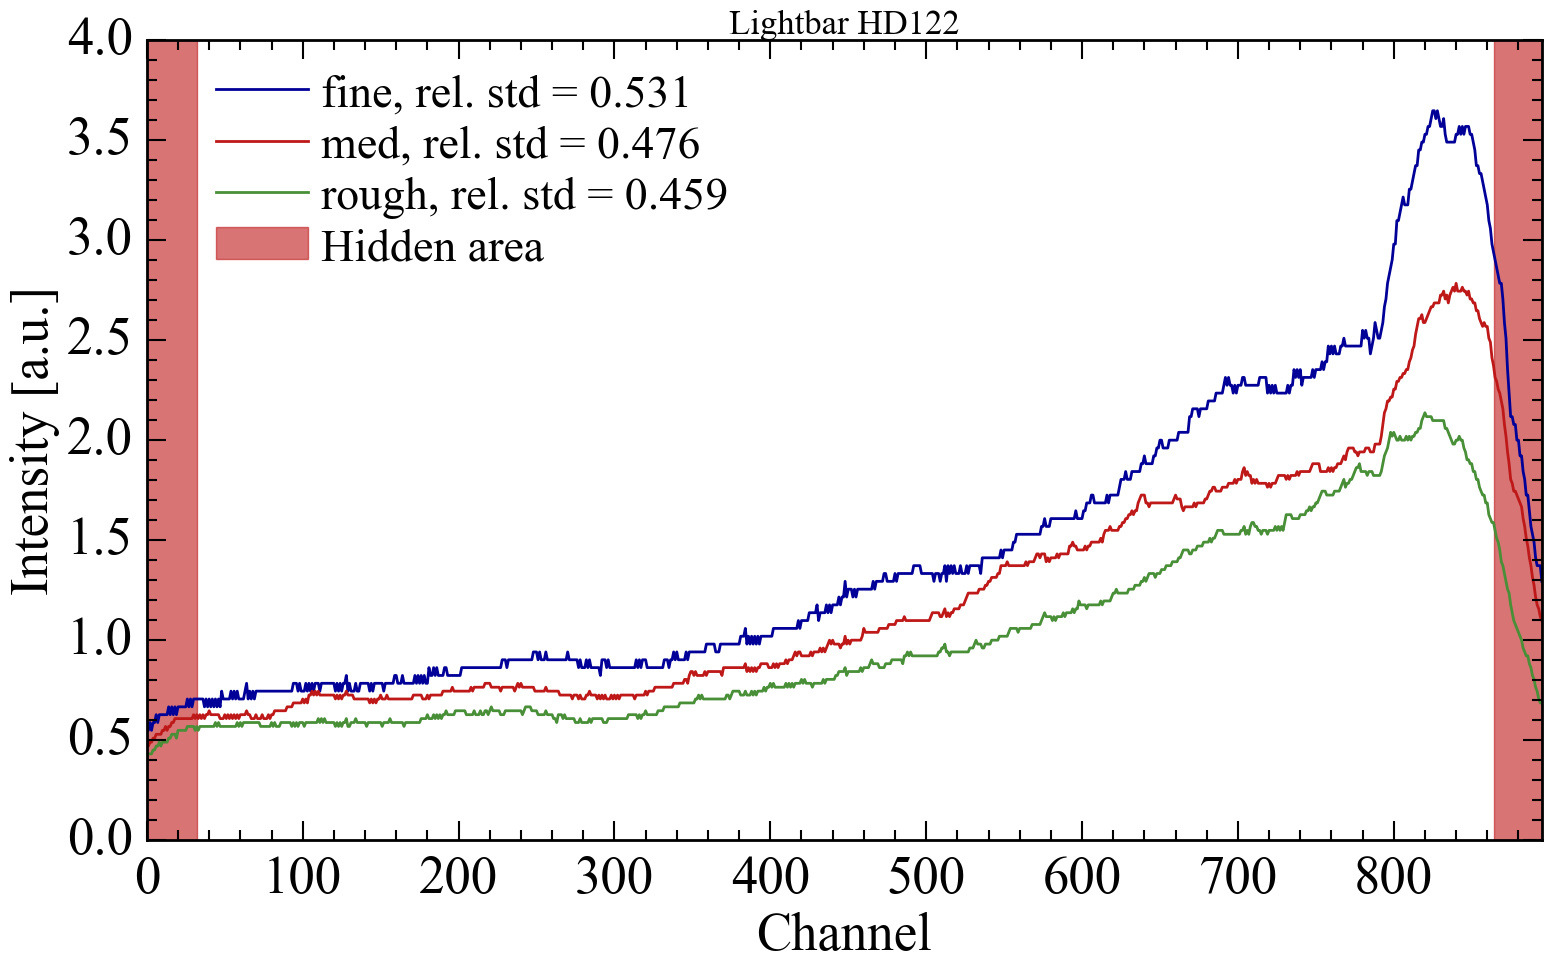

In [249]:
plotbars(lightbars, ["fine", "med", "rough"])

## Distance vs. rough

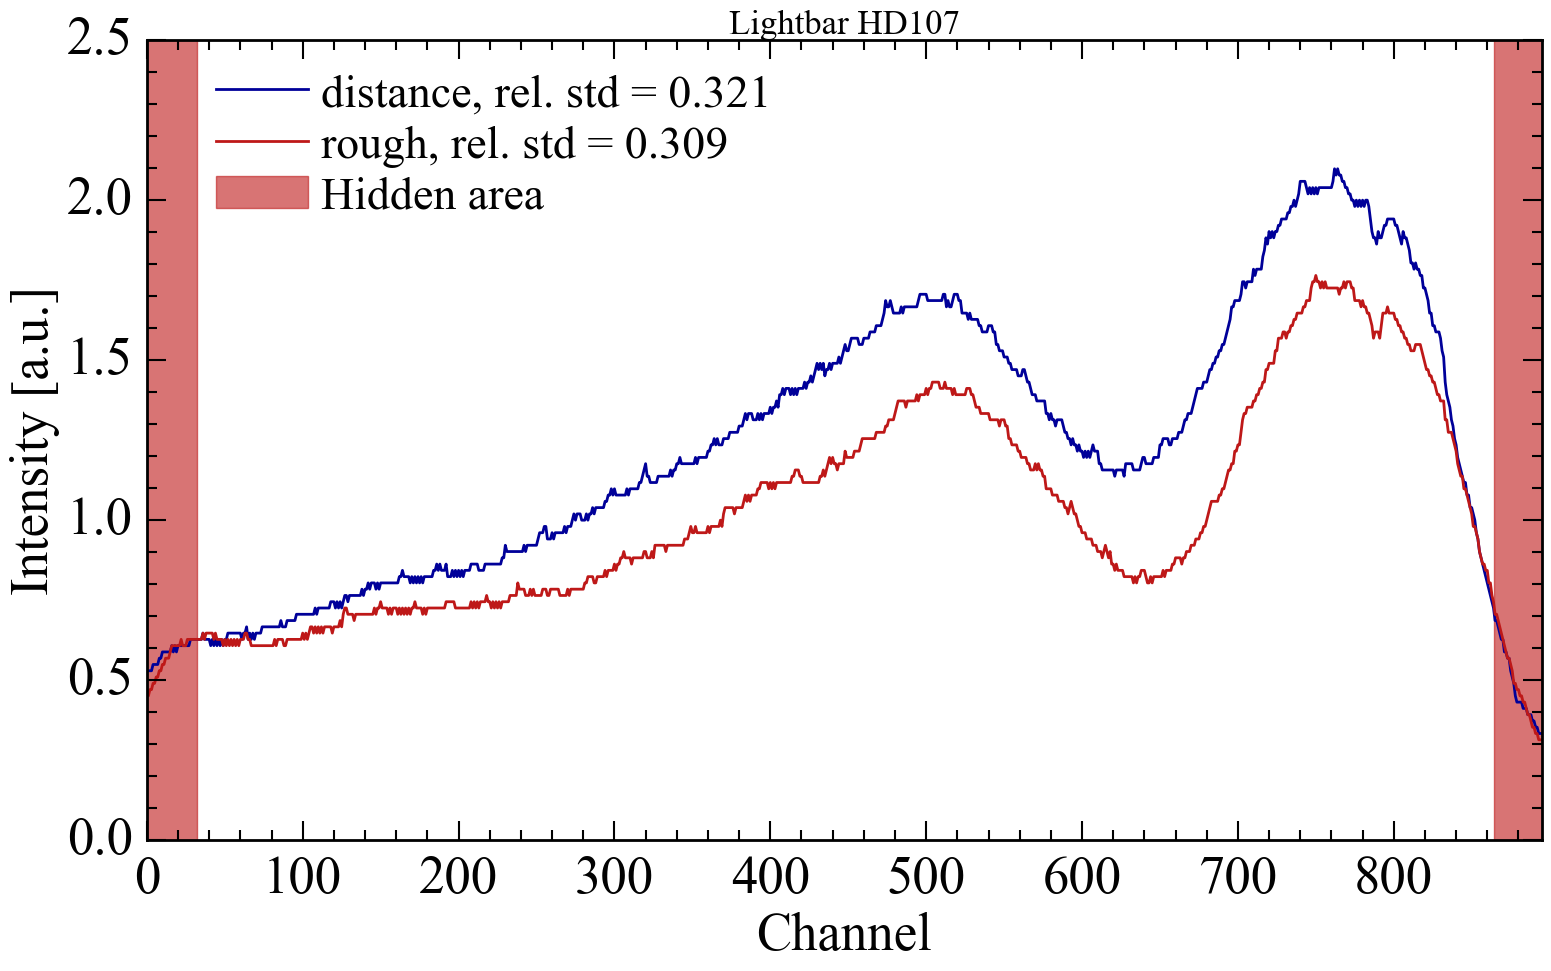

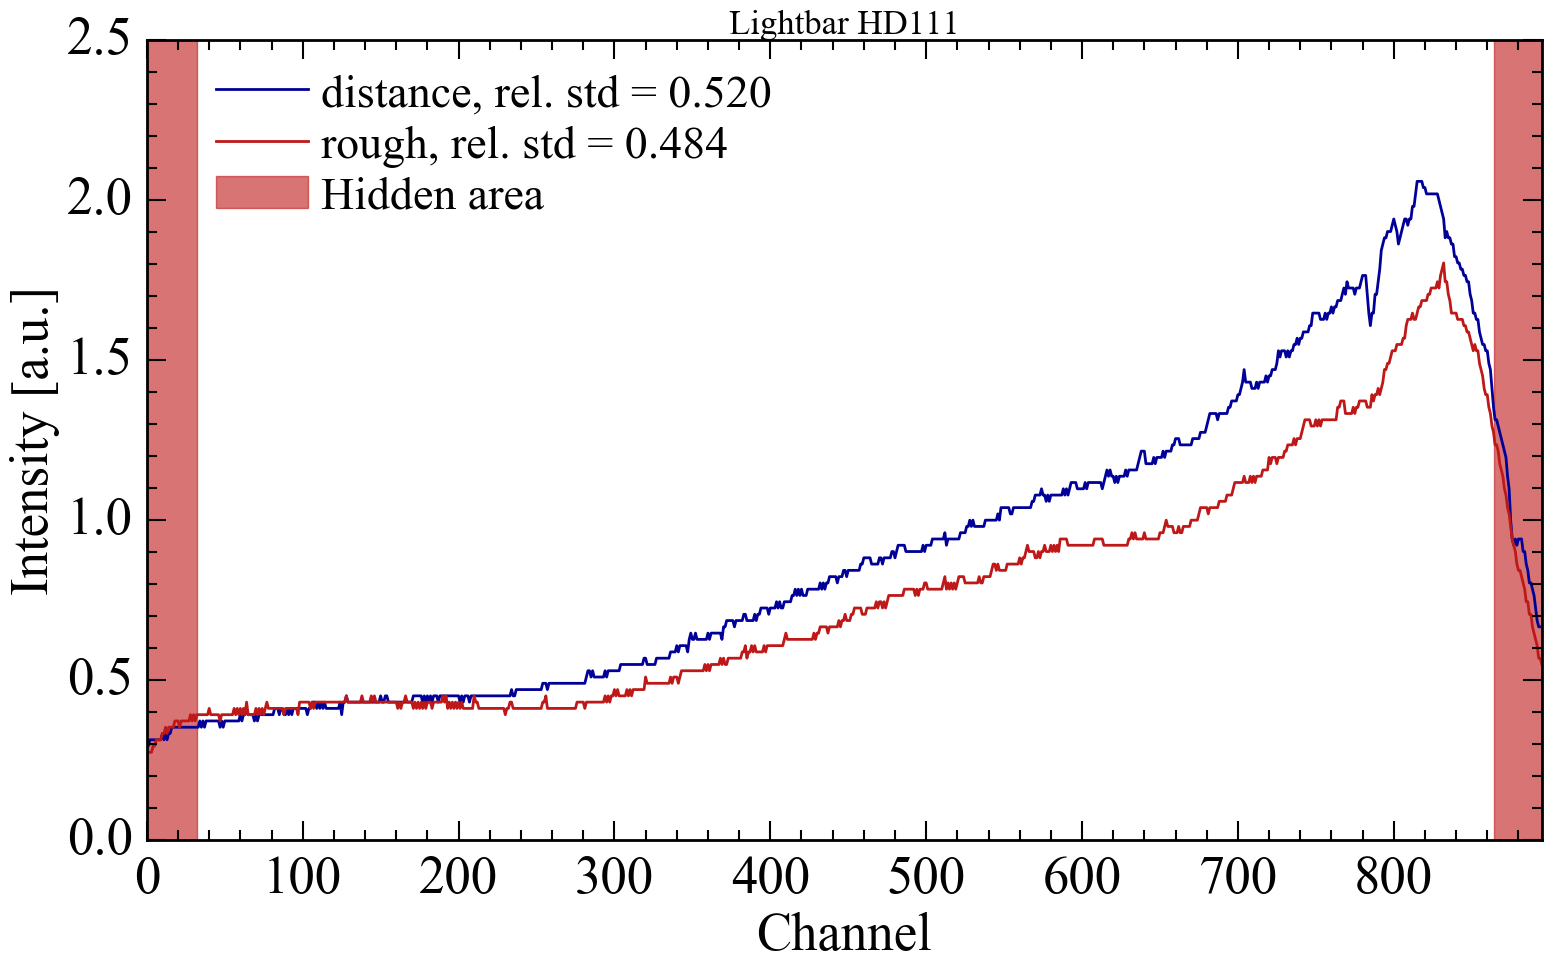

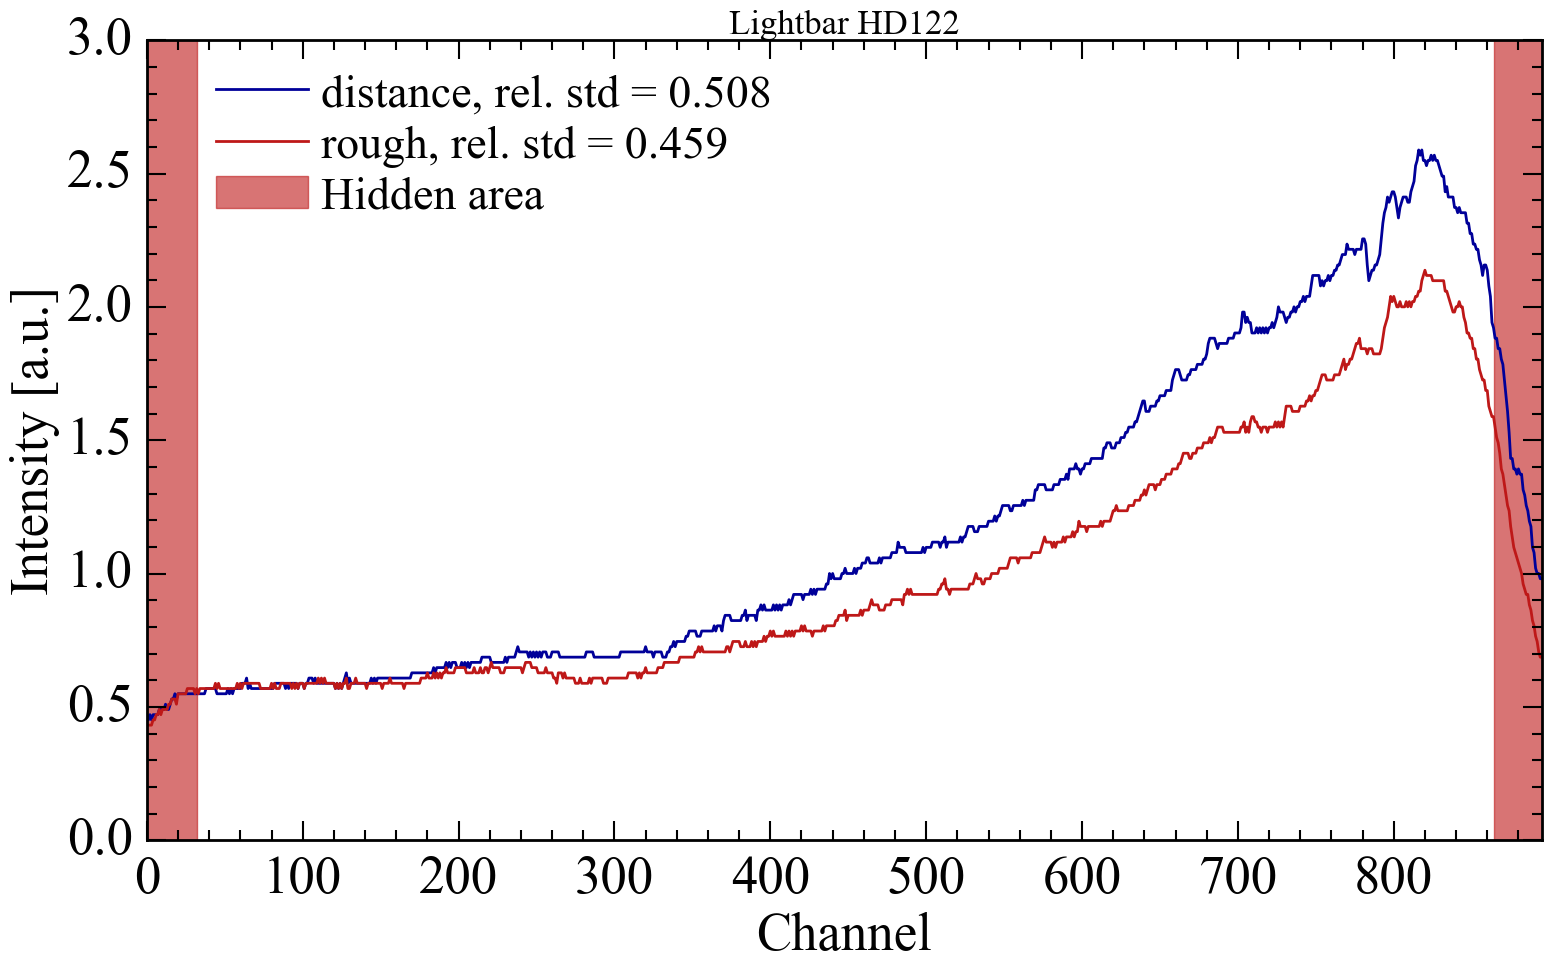

In [250]:
plotbars(lightbars, ["distance", "rough"])

## Mattest measurement

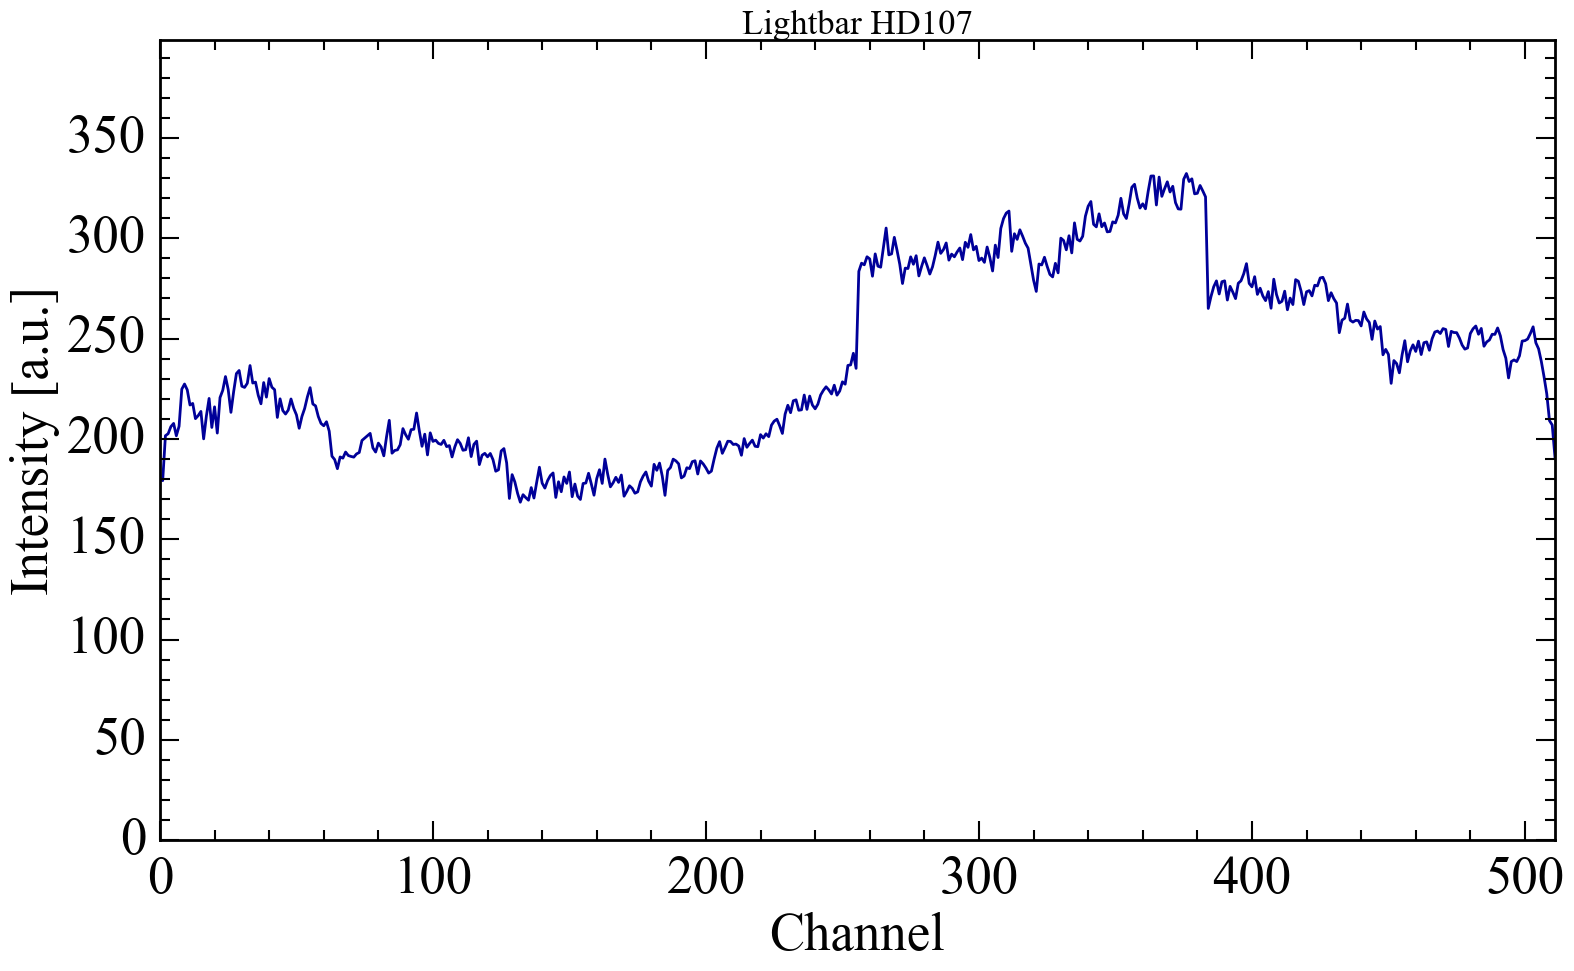

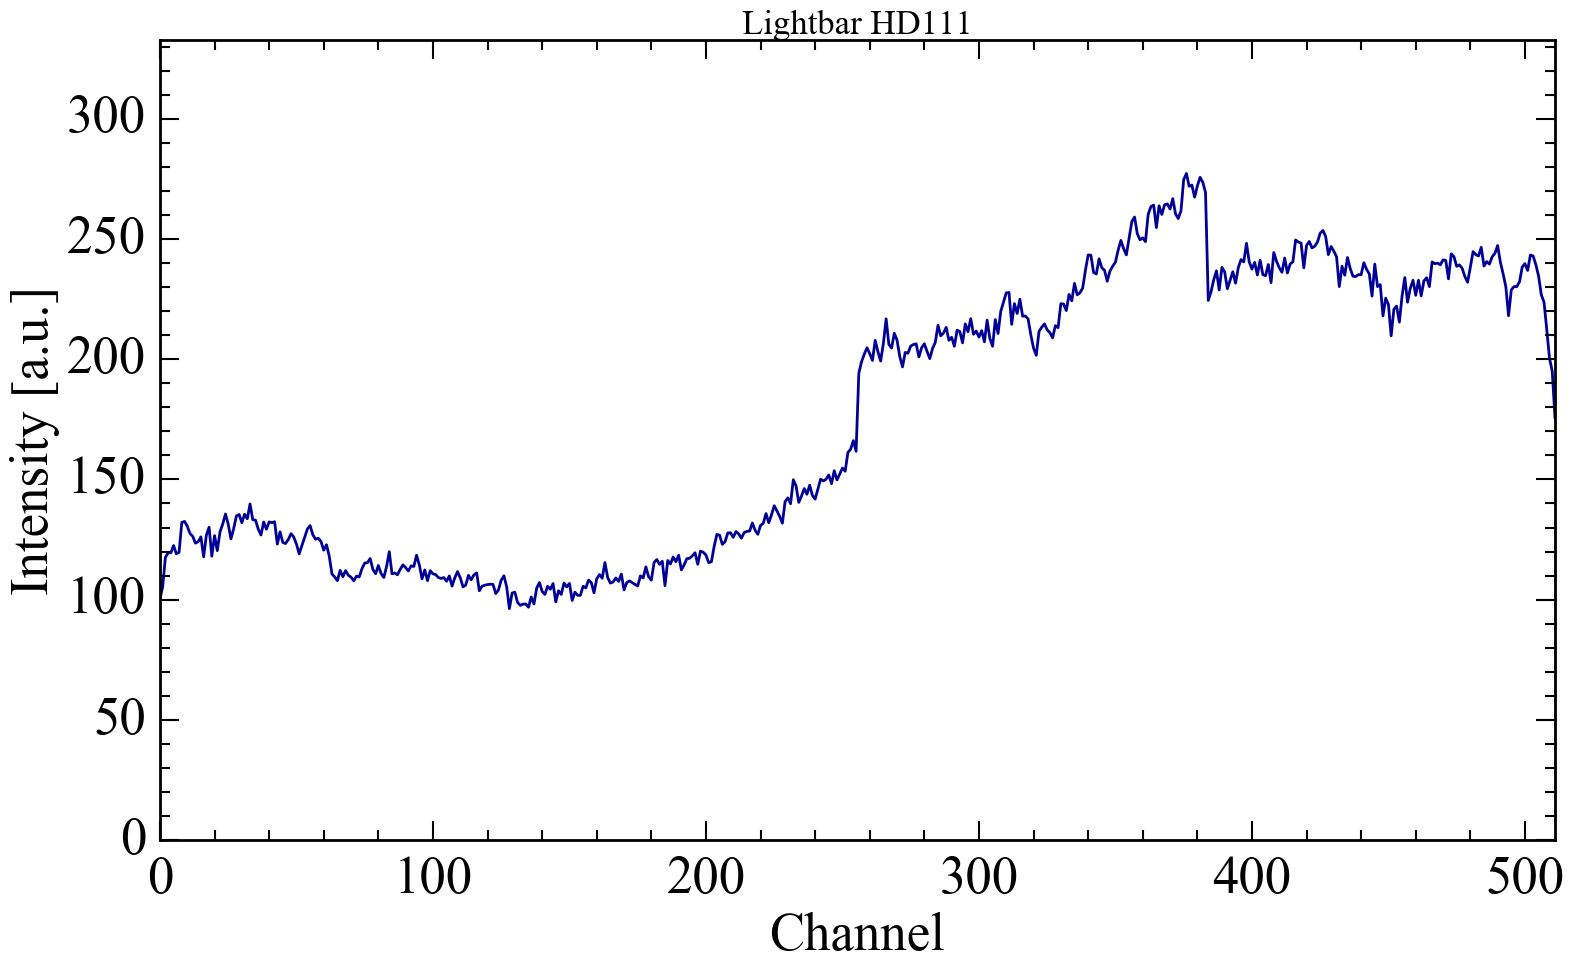

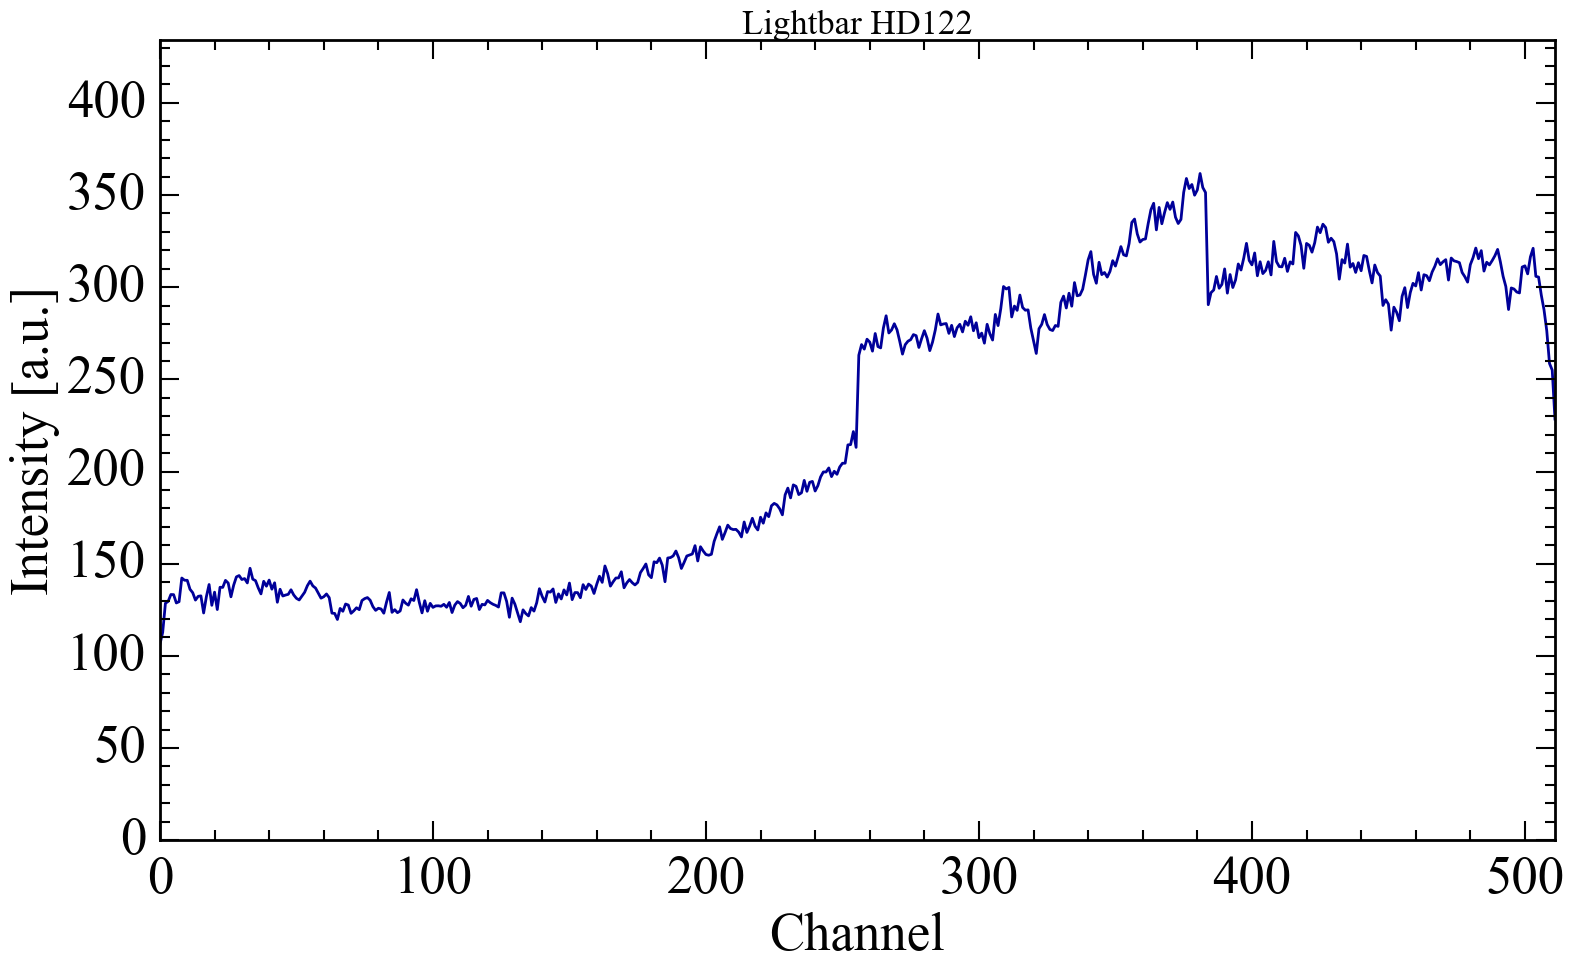

In [258]:
plotmattest(lightbars)